# EDA ACCIDENTES AERONAUTICOS

## Importamos librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from summarytools import dfSummary
import matplotlib.pyplot as plt
import warnings
import folium
from folium.plugins import MarkerCluster


### Cargamos expedientes

In [2]:
expedientes = pd.read_csv(r"C:\Users\maxyf\OneDrive\Escritorio\CV\Proyecto accidentes aeronauticos\Archivos\expedientes_aeronauticos_limpio.csv")

### Outliers

Se realiza una busqueda de Outliers y se analiza la si es necesario eliminarlos

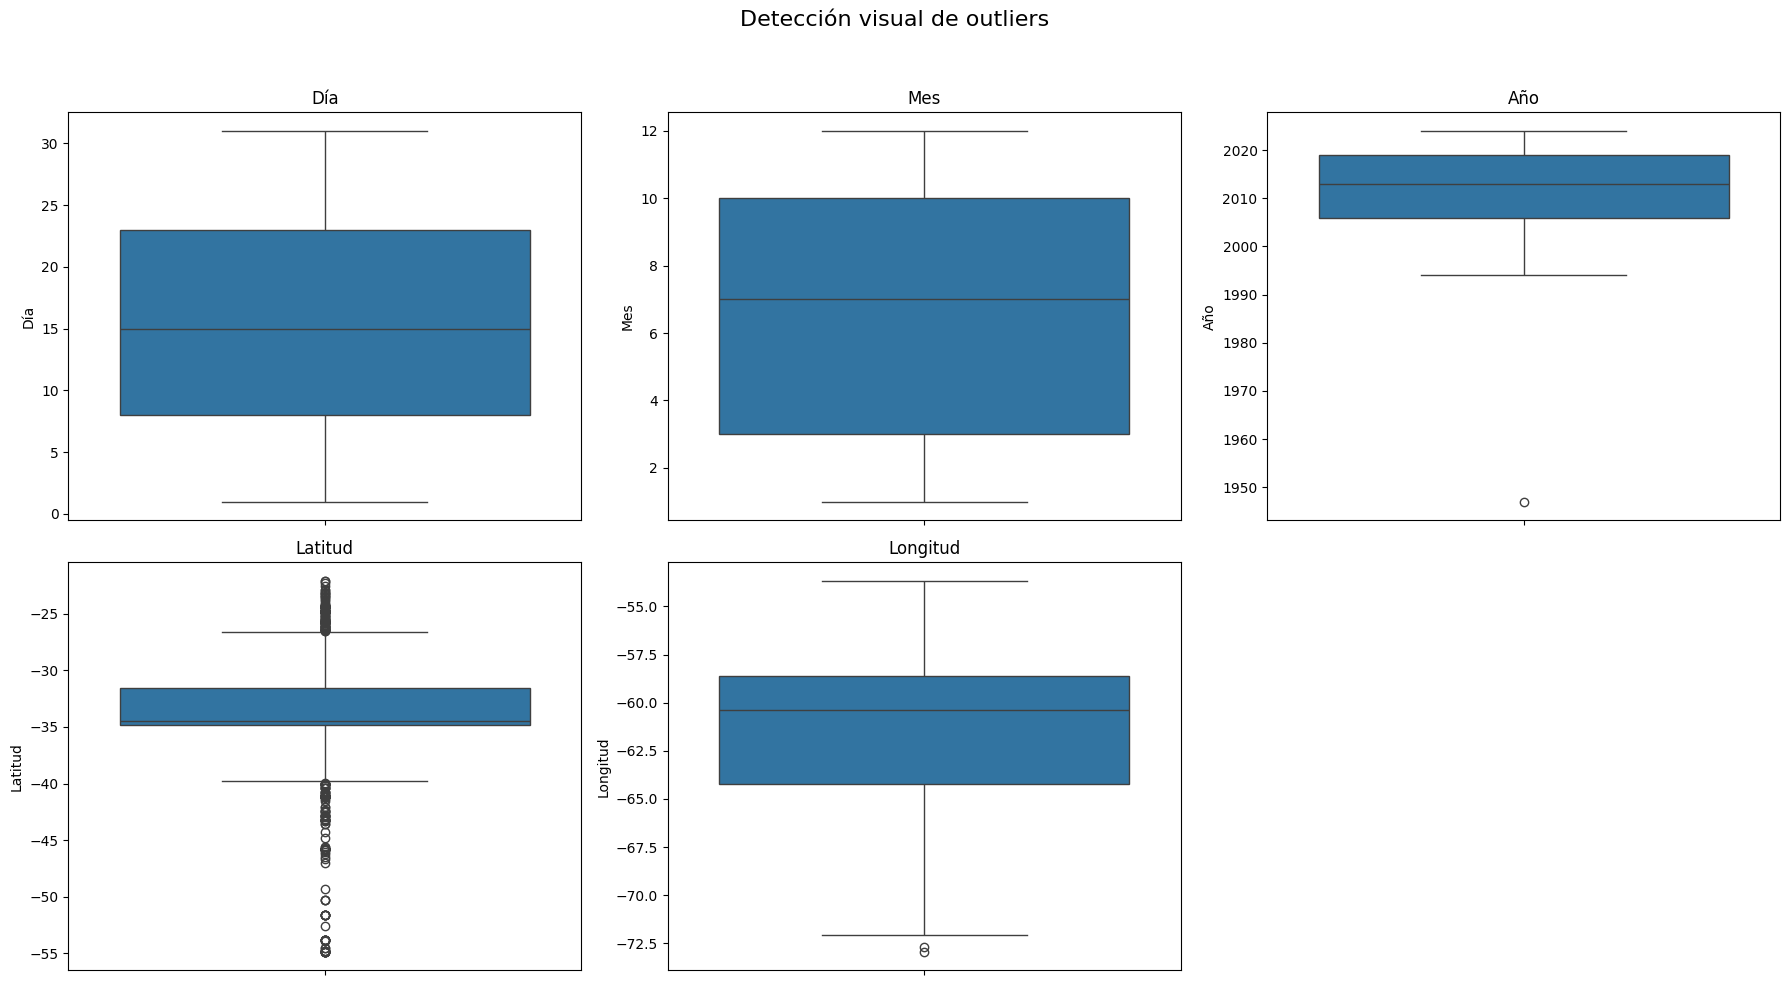

In [3]:
# Crear boxplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Detección visual de outliers', fontsize=16)

# Boxplot para Día
sns.boxplot(data=expedientes, y='Día', ax=axes[0, 0])
axes[0, 0].set_title('Día')

# Boxplot para Mes
sns.boxplot(data=expedientes, y='Mes', ax=axes[0, 1])
axes[0, 1].set_title('Mes')

# Boxplot para Año
sns.boxplot(data=expedientes, y='Año', ax=axes[0, 2])
axes[0, 2].set_title('Año')

# Boxplot para Latitud
sns.boxplot(data=expedientes, y='Latitud', ax=axes[1, 0])
axes[1, 0].set_title('Latitud')

# Boxplot para Longitud
sns.boxplot(data=expedientes, y='Longitud', ax=axes[1, 1])
axes[1, 1].set_title('Longitud')

# Ocultar el último subplot vacío
axes[1, 2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Dejamos los datos Outliers ya que las coordenadas en ese ranfo pueden representar ubicaciones en Argentina


### Variables numéricas


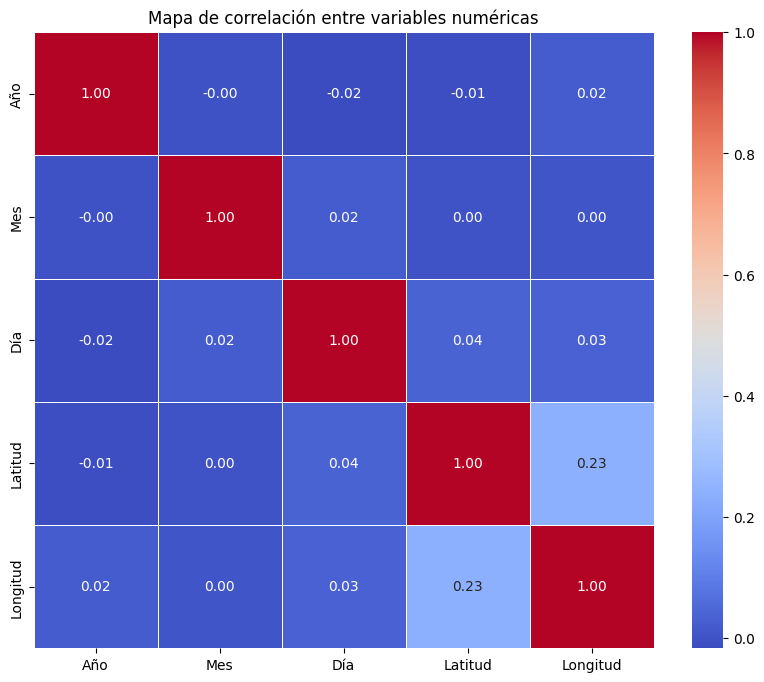

In [4]:
# Seleccionamos solo las columnas numéricas
numericas = expedientes.select_dtypes(include=["float64", "int64"])

# Calculamos la matriz de correlación
correlacion = numericas.corr()

# Creamos el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Mapa de correlación entre variables numéricas")
plt.show()

Podemos ver que no hay alguna correlacion fuerte entre las variantes


### Análisis Temporal – Accidentes por Año

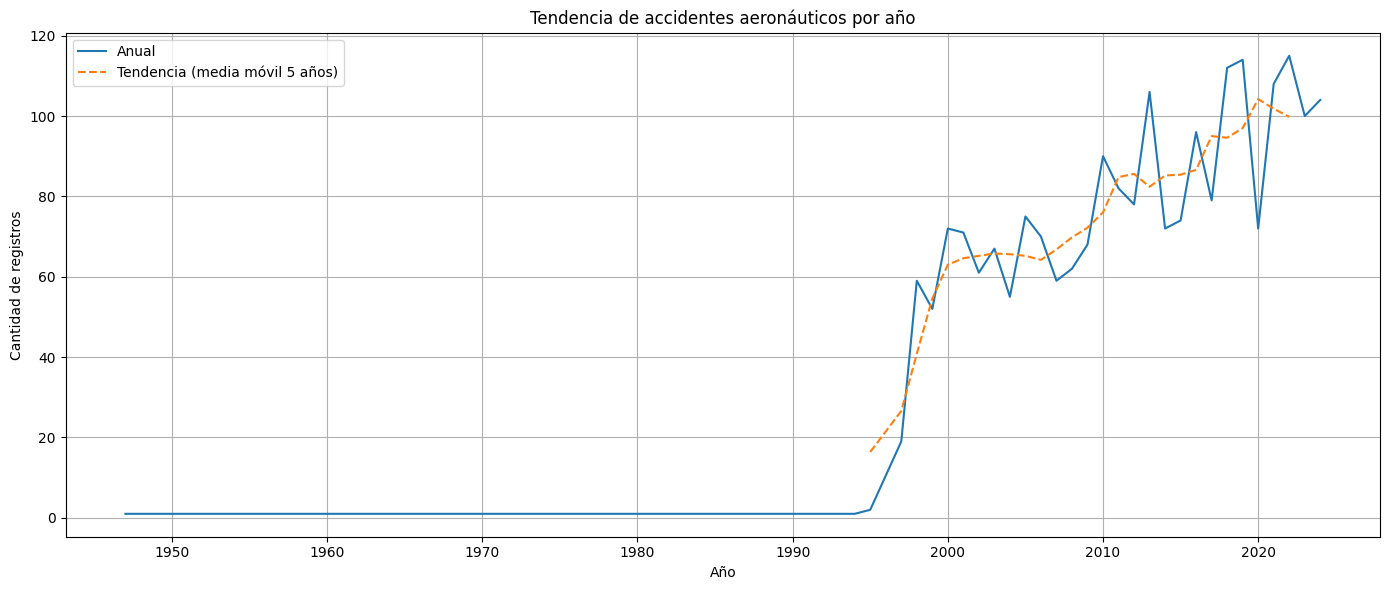

In [5]:
# Media móvil
accidentes_por_año = expedientes['Año'].value_counts().sort_index()
expedientes_año_rolling = accidentes_por_año.rolling(window=5, center=True).mean()

# Graficar con tendencia
plt.figure(figsize=(14, 6))
sns.lineplot(x=accidentes_por_año.index, y=accidentes_por_año.values, label='Anual')
sns.lineplot(x=expedientes_año_rolling.index, y=expedientes_año_rolling.values, label='Tendencia (media móvil 5 años)', linestyle='--')
plt.title('Tendencia de accidentes aeronáuticos por año')
plt.xlabel('Año')
plt.ylabel('Cantidad de registros')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Análisis Temporal – Accidentes por Mes

C:\Users\maxyf\AppData\Local\Temp\ipykernel_14760\2203979754.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=expedientes, x='Mes', palette='crest')


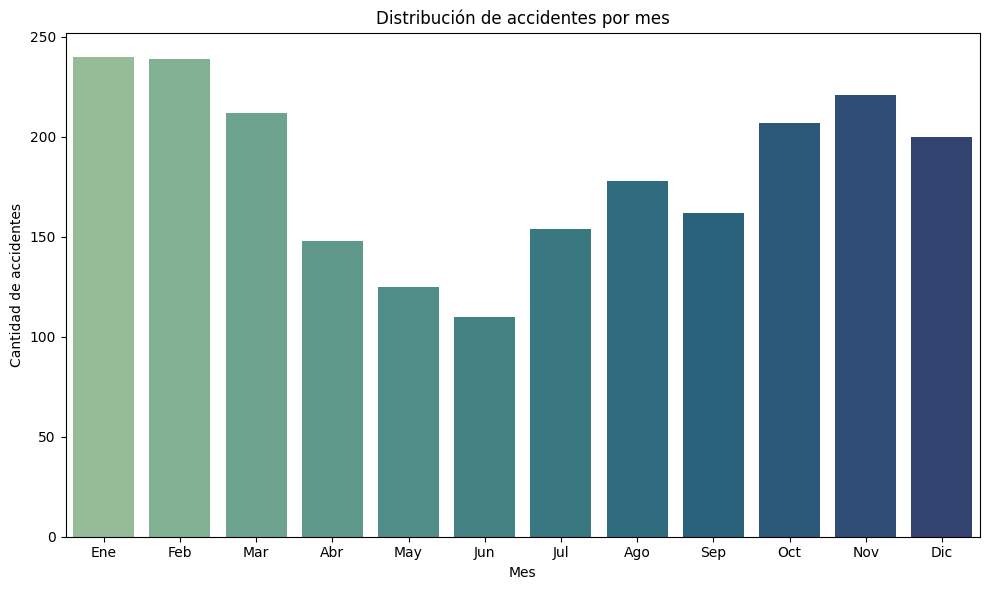

In [6]:
# Asegurate de que la columna 'Mes' sea numérica
expedientes['Mes'] = pd.to_numeric(expedientes['Mes'], errors='coerce')

plt.figure(figsize=(10,6))
sns.countplot(data=expedientes, x='Mes', palette='crest')
plt.title('Distribución de accidentes por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de accidentes')
plt.xticks(ticks=range(0,12), labels=[
    'Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
    'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'
])
plt.tight_layout()
plt.show()

### Análisis Temporal – Accidentes por Día de Mes

C:\Users\maxyf\AppData\Local\Temp\ipykernel_14760\2006641643.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=expedientes, x='Día', palette='viridis')


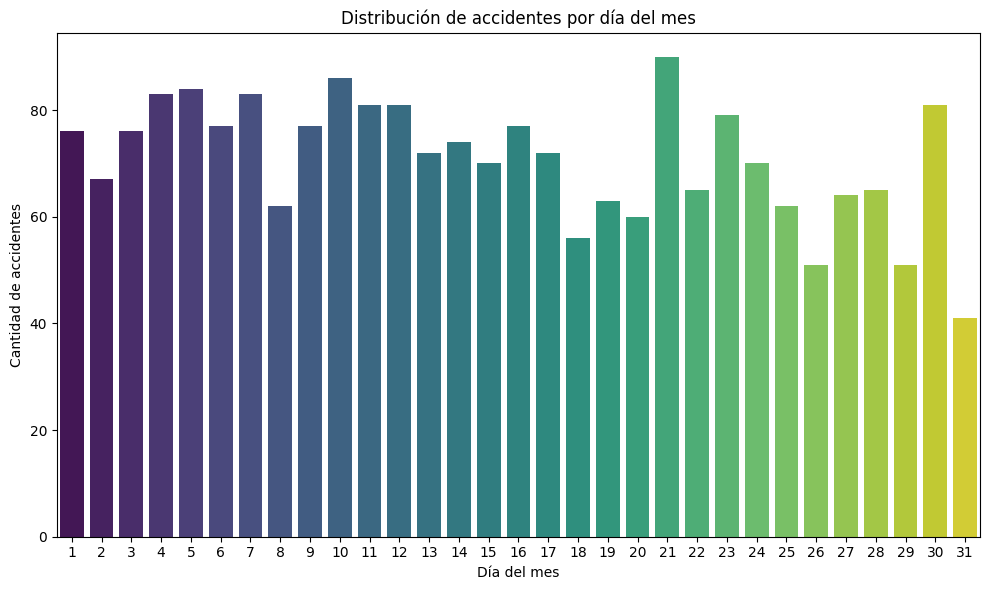

In [7]:
plt.figure(figsize=(10,6))
sns.countplot(data=expedientes, x='Día', palette='viridis')
plt.title('Distribución de accidentes por día del mes')
plt.xlabel('Día del mes')
plt.ylabel('Cantidad de accidentes')
plt.tight_layout()
plt.show()

### Análisis Temporal – Accidentes por Día de Hora

C:\Users\maxyf\AppData\Local\Temp\ipykernel_14760\3471734675.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  horas = pd.to_datetime(expedientes['Hora'], errors='coerce').dt.hour


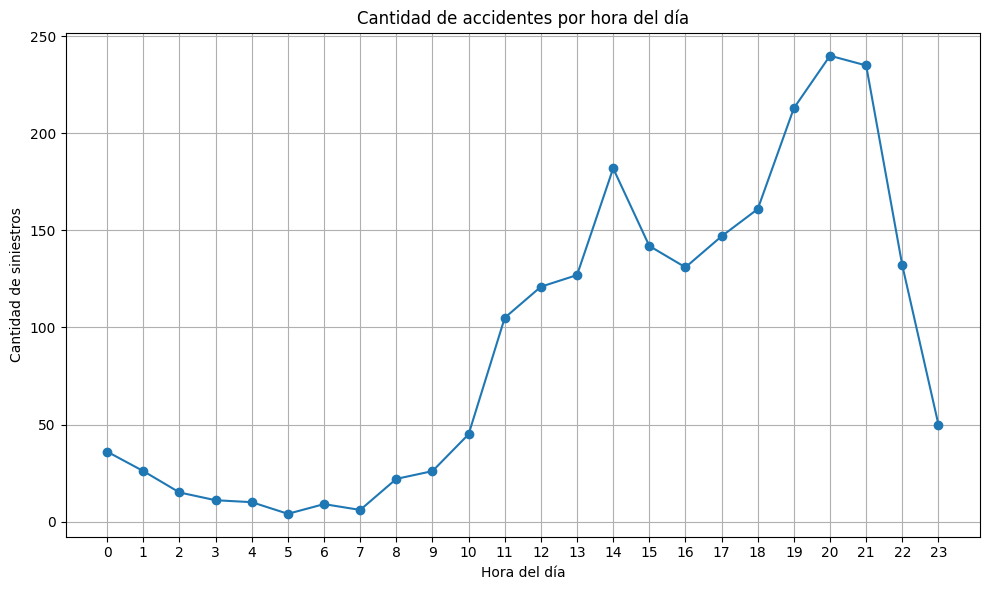

In [8]:
# Paso 1 y 2: Convertir 'Hora' a datetime y extraer la hora directamente (sin agregar columnas)
horas = pd.to_datetime(expedientes['Hora'], errors='coerce').dt.hour

# Paso 3: Contar siniestros por hora, asegurando las 24 horas
horas_completas = pd.DataFrame({'Hora_num': range(24)})
conteo = horas.value_counts().reset_index()
conteo.columns = ['Hora_num', 'Cantidad']
horas_conteo = horas_completas.merge(conteo, on='Hora_num', how='left').fillna(0)
horas_conteo['Cantidad'] = horas_conteo['Cantidad'].astype(int)

# Paso 4: Gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(horas_conteo['Hora_num'], horas_conteo['Cantidad'], marker='o')
plt.title('Cantidad de accidentes por hora del día')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de siniestros')
plt.xticks(range(24))
plt.grid(True)
plt.tight_layout()
plt.show()

### Analisis de Accidentes por Ubicación

In [9]:

# Correcciones de coordenadas según el índice
correcciones = {
    1972:  (-43.61256, -71.02095),                           # Estancia Tecka Airport
    237:   (-34.6822, -59.0347), 87: (-34.6822, -59.0347),   # Aeródromo General Rodríguez
    1900:  (-34.6822, -59.0347), 1875: (-34.6822, -59.0347),
    1825:  (-34.6822, -59.0347),
    232: (-34.6822, -59.0347),
    627:   (-32.8700, -68.8300),                             # Newbery, Mendoza
    2166:  (-36.1153, -57.8567),                             # Paraje India Muerta
    623:   (-34.8222, -58.5358), 615: (-34.8222, -58.5358),  # Ezeiza
    2046:  (-26.7000, -60.7333),                             # Avia Terai, Chaco
    1964:  (-32.6167, -60.2000),                             # Zona rural Victoria, Entre Ríos
    1952:  (-32.2656, -58.0930),                             # Zona Rural Rio Uruguay - Colón
    1894:  (-54.23355, -67.21325)                            # Helipuerto Antártida
}

for idx, (lat, lon) in correcciones.items():
    expedientes.loc[idx, "Latitud"] = lat
    expedientes.loc[idx, "Longitud"] = lon

# Borrar registros con errores graves según el índice
indices_a_borrar = [1298, 589, 949, 293, 185, 1303, 202, 504, 1284, 362, 381, 1320, 24, 1463]
expedientes.drop(index=indices_a_borrar, inplace=True)

In [12]:
# Crear mapa centrado en Argentina
m = folium.Map(location=[-38.4161, -63.6167], zoom_start=5)

# Crear clúster de marcadores
marker_cluster = MarkerCluster().add_to(m)

# Iterar por los registros con coordenadas válidas
for _, row in expedientes.dropna(subset=['Latitud', 'Longitud']).iterrows():
    folium.Marker(
        location=[row['Latitud'], row['Longitud']],
        popup=f"Año: {row['Año']}<br>Lugar: {row['Lugar']}<br>Lugar: {row['Lugar']}"
    ).add_to(marker_cluster)

# Mostrar mapa
m

### Analisis del vehículo 1

#### Análisis de la fase del accidente

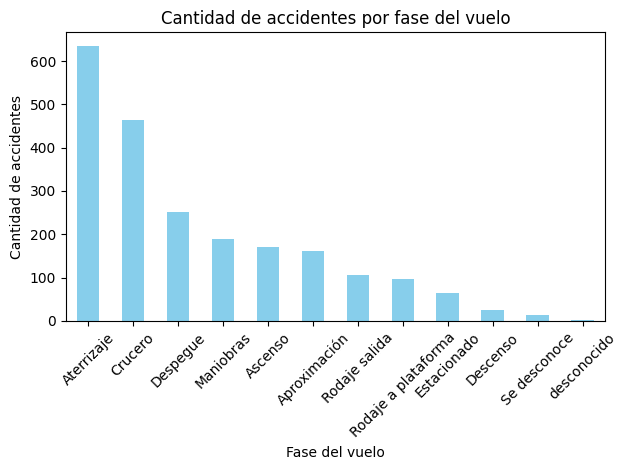

In [ ]:
# Contar ocurrencias por fase (ignorando nulos)
expedientes['Vehículo 1 - fase'].dropna().value_counts().plot(kind='bar', color='skyblue')

plt.title('Cantidad de accidentes por fase del vuelo')
plt.xlabel('Fase del vuelo')
plt.ylabel('Cantidad de accidentes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Análisis del tipo de aeronave


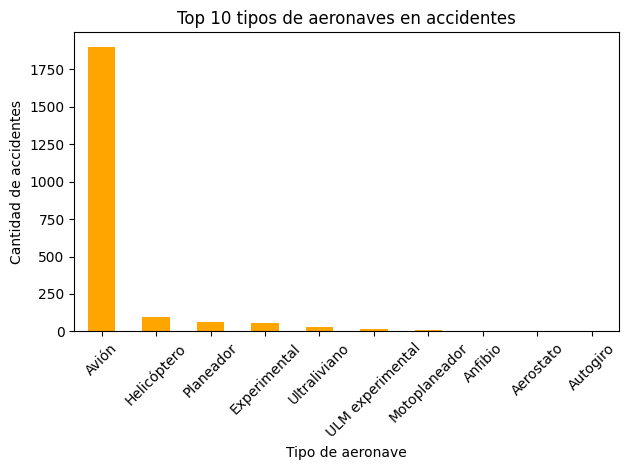

In [19]:
# Mostrar los 10 tipos de aeronave más comunes
expedientes['Vehículo 1 - tipo'].dropna().value_counts().head(10).plot(kind='bar', color='orange')

plt.title('Top 10 tipos de aeronaves en accidentes')
plt.xlabel('Tipo de aeronave')
plt.ylabel('Cantidad de accidentes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Eran experimentales?

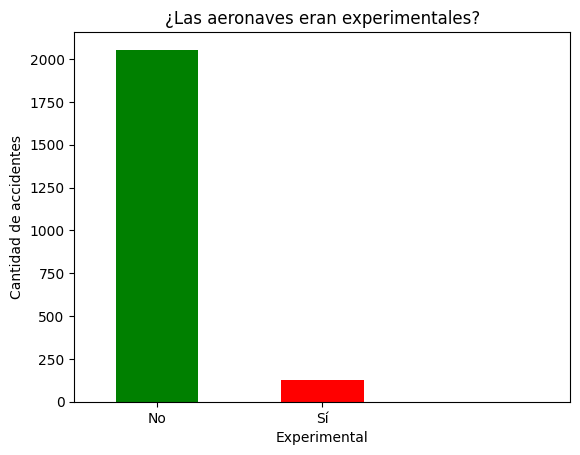

In [21]:
expedientes['Vehículo 1 - experimental'].value_counts().plot(
    kind='bar', color=['green', 'red']
)

plt.title('¿Las aeronaves eran experimentales?')
plt.xlabel('Experimental')
plt.ylabel('Cantidad de accidentes')
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'], rotation=0)
plt.show()

#### Tipo de aeronave

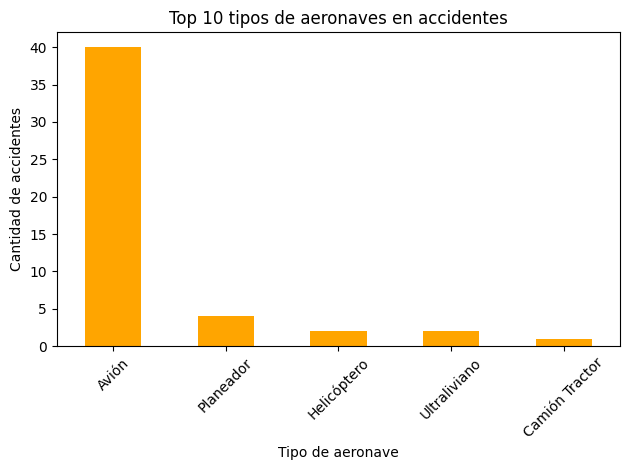

In [23]:
# Mostrar los 10 tipos de aeronave más comunes
expedientes['Vehículo 2 - tipo'].dropna().value_counts().head(10).plot(kind='bar', color='orange')

plt.title('Top 10 tipos de aeronaves en accidentes')
plt.xlabel('Tipo de aeronave')
plt.ylabel('Cantidad de accidentes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Eran aeronaves experimentales o no

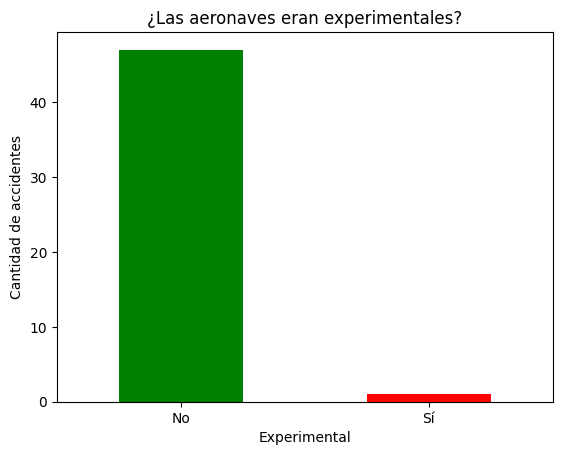

In [ ]:
expedientes['Vehículo 2 - experimental'].value_counts().plot(
    kind='bar', color=['green', 'red']
)

plt.title('¿Las aeronaves eran experimentales?')
plt.xlabel('Experimental')
plt.ylabel('Cantidad de accidentes')
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'], rotation=0)
plt.show()

#### Marca de la aeronave

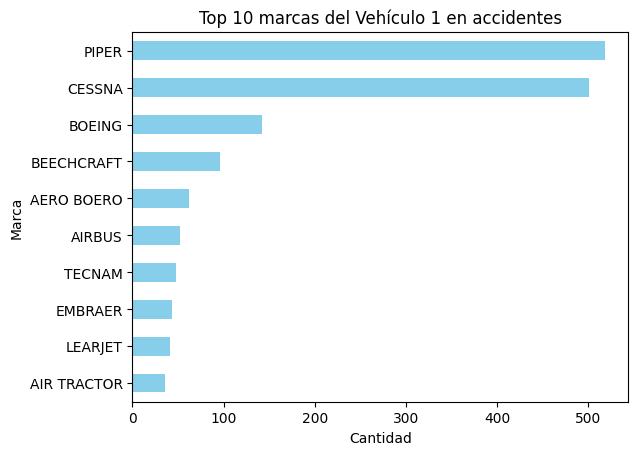

In [ ]:
expedientes['Vehículo 1 - marca'].value_counts().head(10).plot(
    kind='barh', color='skyblue'
)

plt.title('Top 10 marcas del Vehículo 1 en accidentes')
plt.xlabel('Cantidad')
plt.ylabel('Marca')
plt.gca().invert_yaxis()  
plt.show()

#### Modelo de la aeronave

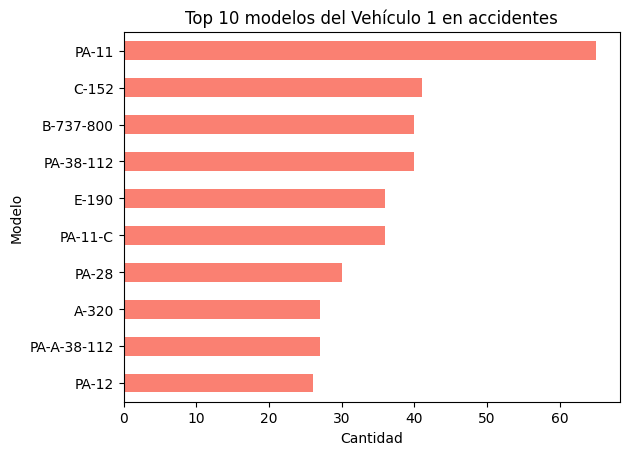

In [34]:
expedientes['Vehículo 1 - modelo'].value_counts().head(10).plot(
    kind='barh', color='salmon'
)

plt.title('Top 10 modelos del Vehículo 1 en accidentes')
plt.xlabel('Cantidad')
plt.ylabel('Modelo')
plt.gca().invert_yaxis()
plt.show()

#### Suceso

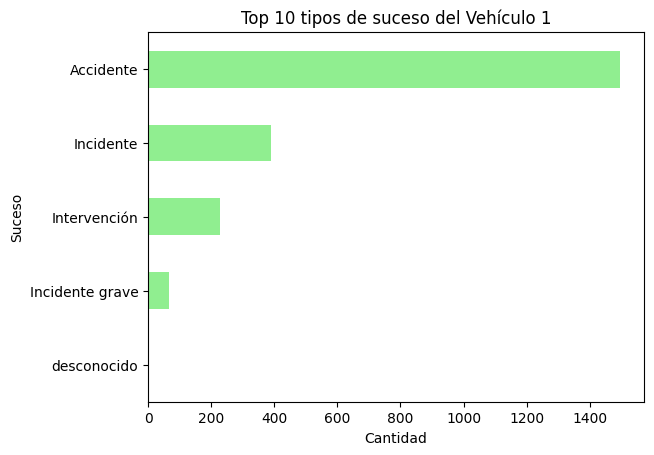

In [35]:
expedientes['Vehículo 1 - suceso'].value_counts().head(10).plot(
    kind='barh', color='lightgreen'
)
plt.title('Top 10 tipos de suceso del Vehículo 1')
plt.xlabel('Cantidad')
plt.ylabel('Suceso')
plt.gca().invert_yaxis()
plt.show()


#### Tipo de operacion 

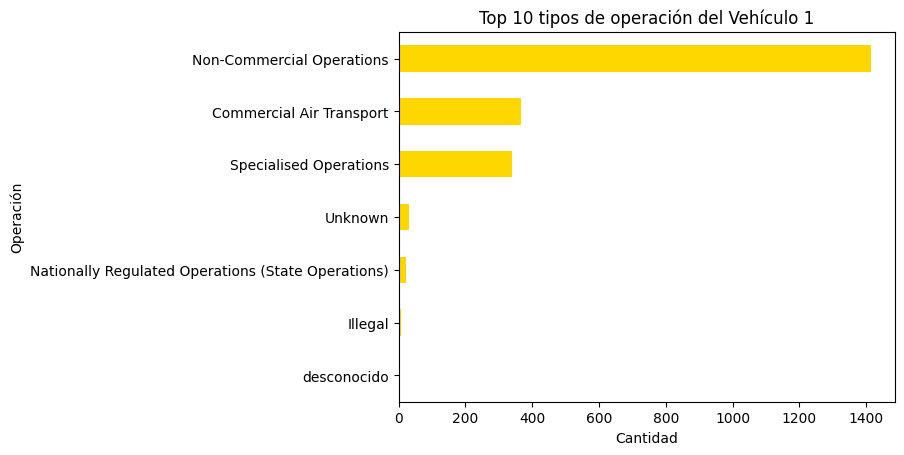

In [37]:
expedientes['Vehículo 1 - operacion'].value_counts().head(10).plot(
    kind='barh', color='gold'
)
plt.title('Top 10 tipos de operación del Vehículo 1')
plt.xlabel('Cantidad')
plt.ylabel('Operación')
plt.gca().invert_yaxis()
plt.show()


#### Nivel de daño

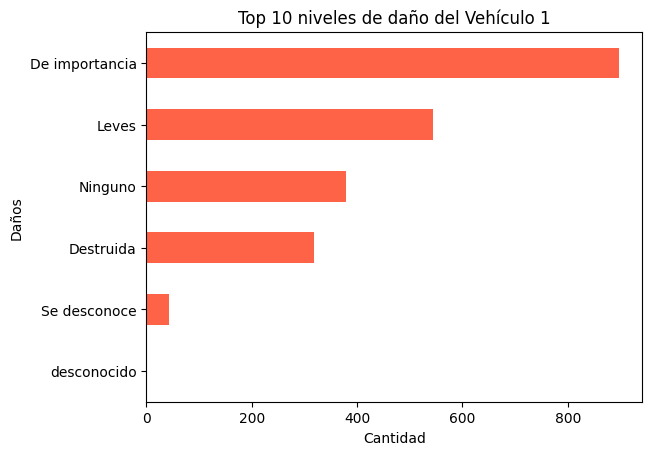

In [38]:
expedientes['Vehículo 1 - daños'].value_counts().head(10).plot(
    kind='barh', color='tomato'
)
plt.title('Top 10 niveles de daño del Vehículo 1')
plt.xlabel('Cantidad')
plt.ylabel('Daños')
plt.gca().invert_yaxis()
plt.show()


#### Razón del accidente

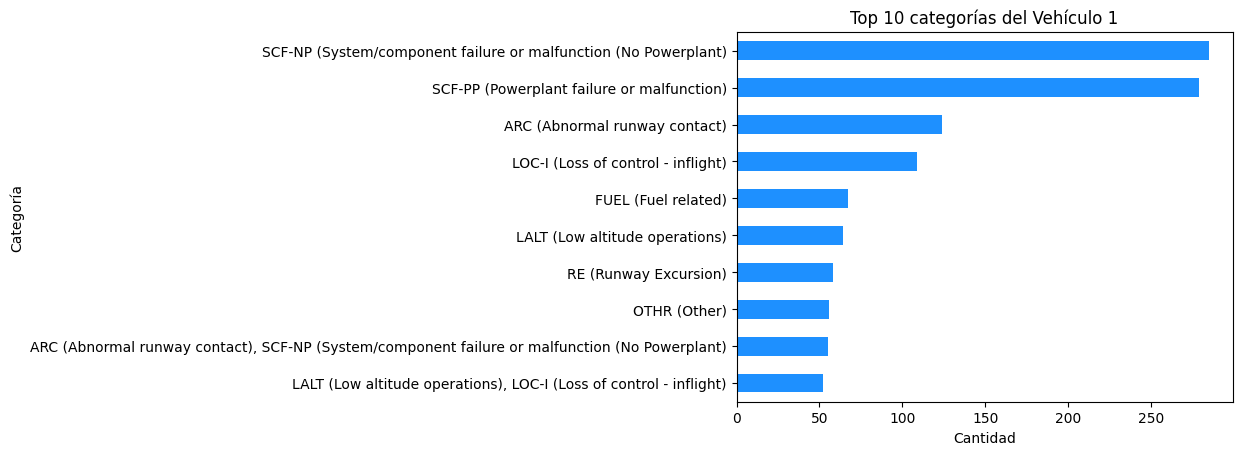

In [39]:
expedientes['Vehículo 1 - categoria'].value_counts().head(10).plot(
    kind='barh', color='dodgerblue'
)
plt.title('Top 10 categorías del Vehículo 1')
plt.xlabel('Cantidad')
plt.ylabel('Categoría')
plt.gca().invert_yaxis()
plt.show()


### Análisis del vehículo 2

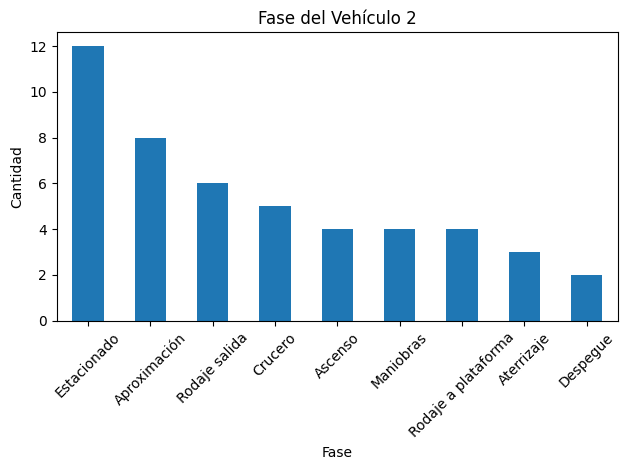

In [43]:
expedientes['Vehículo 2 - fase'].dropna().value_counts().plot(kind='bar', title='Fase del Vehículo 2')
plt.xlabel('Fase')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

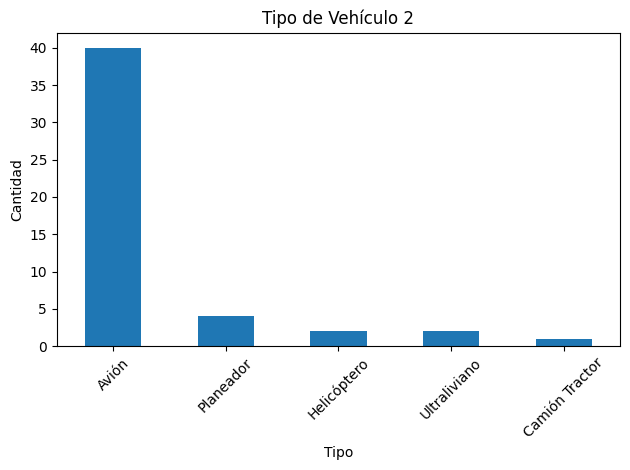

In [44]:
expedientes['Vehículo 2 - tipo'].dropna().value_counts().plot(kind='bar', title='Tipo de Vehículo 2')
plt.xlabel('Tipo')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

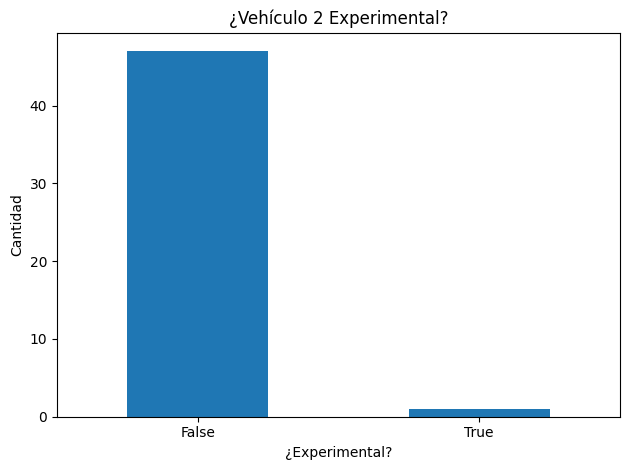

In [45]:
expedientes['Vehículo 2 - experimental'].dropna().value_counts().plot(kind='bar', title='¿Vehículo 2 Experimental?')
plt.xlabel('¿Experimental?')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

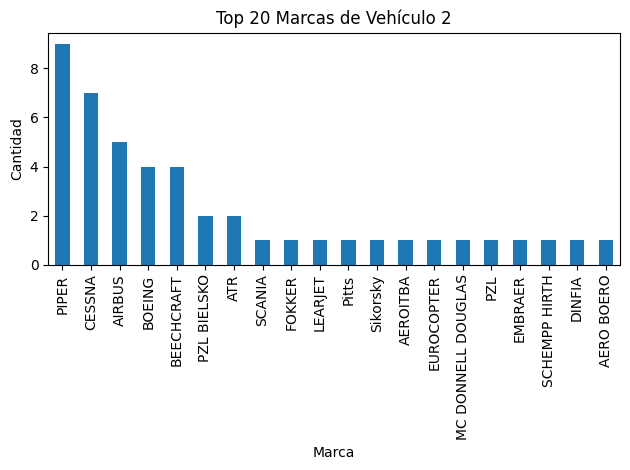

In [46]:
expedientes['Vehículo 2 - marca'].dropna().value_counts().head(20).plot(kind='bar', title='Top 20 Marcas de Vehículo 2')
plt.xlabel('Marca')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

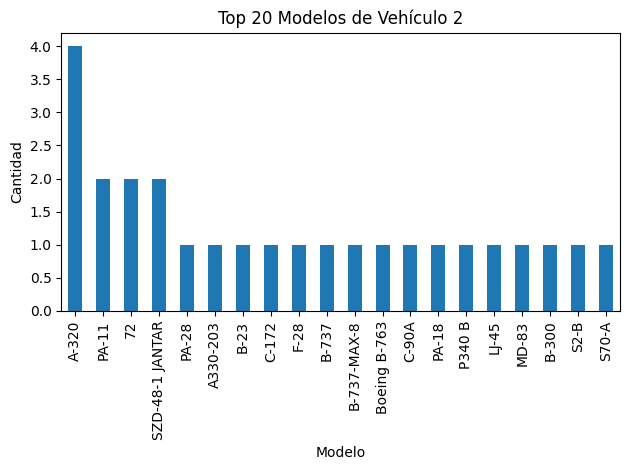

In [47]:
expedientes['Vehículo 2 - modelo'].dropna().value_counts().head(20).plot(kind='bar', title='Top 20 Modelos de Vehículo 2')
plt.xlabel('Modelo')
plt.ylabel('Cantidad')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

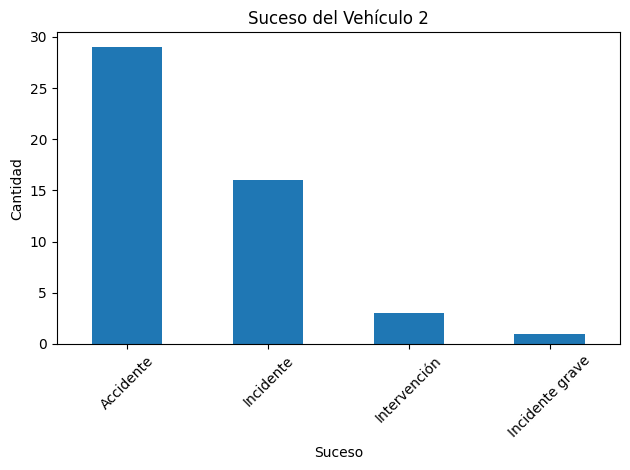

In [48]:
expedientes['Vehículo 2 - suceso'].dropna().value_counts().plot(kind='bar', title='Suceso del Vehículo 2')
plt.xlabel('Suceso')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

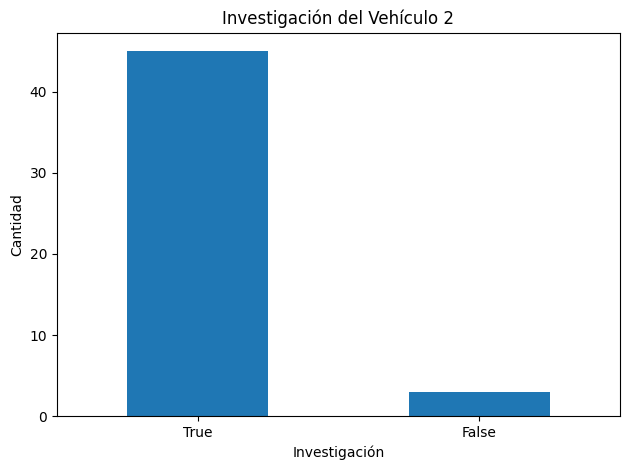

In [49]:
expedientes['Vehículo 2 - investigacion'].dropna().value_counts().plot(kind='bar', title='Investigación del Vehículo 2')
plt.xlabel('Investigación')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

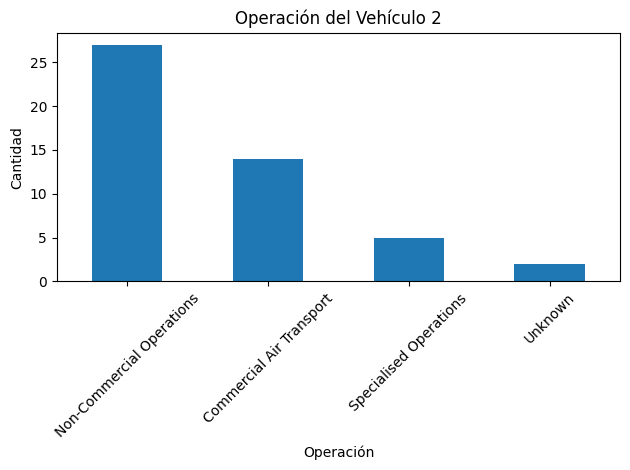

In [50]:
expedientes['Vehículo 2 - operacion'].dropna().value_counts().plot(kind='bar', title='Operación del Vehículo 2')
plt.xlabel('Operación')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

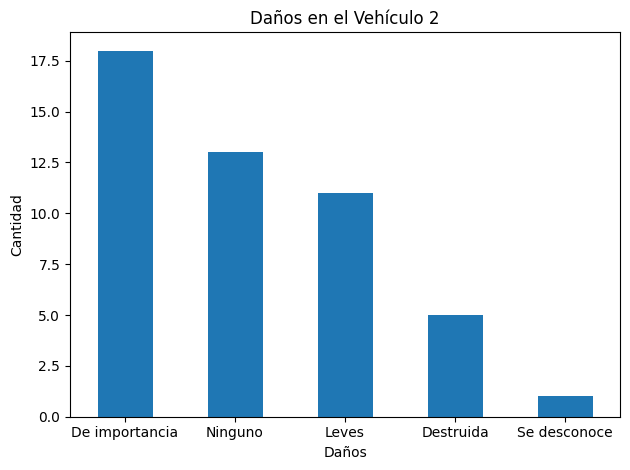

In [51]:
expedientes['Vehículo 2 - daños'].dropna().value_counts().plot(kind='bar', title='Daños en el Vehículo 2')
plt.xlabel('Daños')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

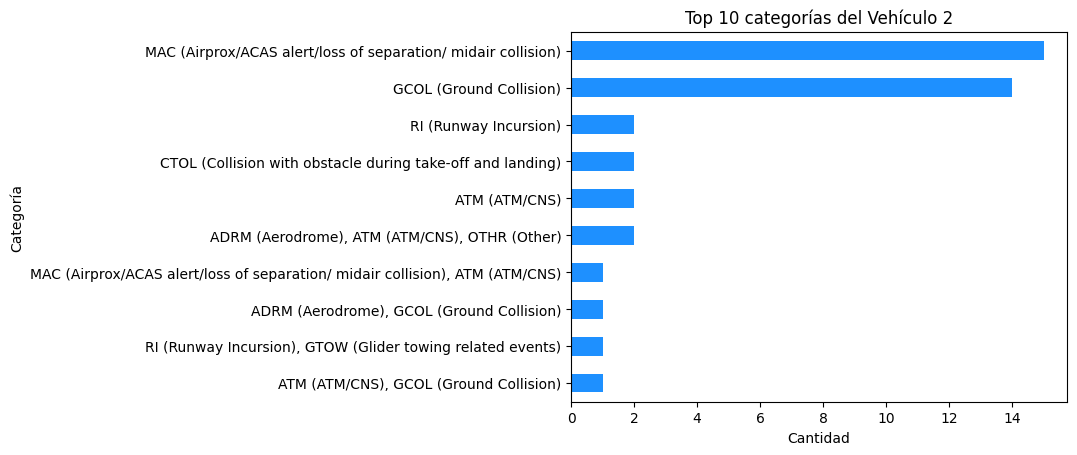

In [53]:
expedientes['Vehículo 2 - categoria'].value_counts().head(10).plot(
    kind='barh', color='dodgerblue'
)
plt.title('Top 10 categorías del Vehículo 2')
plt.xlabel('Cantidad')
plt.ylabel('Categoría')
plt.gca().invert_yaxis()
plt.show()